## 7. 앙상블 학습과 랜던 포레스트

---

### 7.1 투표 기반 분류기

### 7.2 배깅과 페이스팅
> #### 7.2.1 사이킷런 배깅과 페이스팅
> #### 7.2.2 Out-Of-Bag 평가 

### 7.3 랜덤 패치와 랜던 서브스페이스

### 7.4 랜덤 포레스트
> #### 7.4.1 엑스트라 트리
> #### 7.4.2 특성 중요도

### 7.5 부스팅
> #### 7.5.1 아다부스트
> #### 7.5.2 그래디언트 부스팅 

### 7.6 스태킹

----

#### 들어가며 

- 대중의 지혜 ( wisdom of the crowd ) 
> - 일련의 예측기 (분류,회귀)로부터 예측을 수집했을 때, 가장 좋은 모델 하나보다 더 좋은 예측을 얻음 

- 앙상블
> - 일련의 예측기 

- 랜덤 포레스트
> - 결정트리의 앙상블
> - 훈련 세트로 부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련
> - 모든 개별 트리의 예측을 구하여, 가장 많은 선택을 받은 클래스를 예측 결과





#### 7.1 투표 기반 분류기
---

- 정확도가 80%인 분류기를 여러개 훈련 
> - 로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, KNN 분류기
- 더 좋은 분류기를 만드는 매우 간단한 방법은 <strong>'각 분류기의 예측을 모아 가장 많이 선택된 클래스를 예측'</strong>
- 이렇게 다수결 투표로 정해지는 분류기를 <strong> ' 직접 투표 분류기 ( Hard Voting ) ' </strong>

 > - 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것 보다도 정확도가 높을 경우우가 많음
 > - 각 분류기가 약한 분류기 <strong>( weak learner = 랜덤 추측보다 조금 더 높은 성능을 내는 분류기 )</strong> 일지라도 
 > - 다양하다면 앙상블은 강한 학습기 <strong>( strong learner )</strong> 가 됌

어떻게? 
 - 큰 수의 법칙 ( Law of large Numbers )  - 이항 분포의 확률 질량 함수로 계산 

> - 동전을 던졌을 때 앞면 51%, 뒷면 49%가 나오는 조금 균형이 맞지 않은 동전이 있다고 가정
> - 1000 번 던지면, 510번 앞면, 490번 뒷면 나올 것으로 다수는 앞면
> - 1000 번 던진 후, 앞면이 다수가 될 확률은 75% 가까워짐 
> - 더 많이 던질수록 확률은 증가 ( 10,000번 던지면 앞면이 절반 이상일 확률이 97% 이상으로 올라감 )


- 이와 비슷하게 51% 정확도를 가진 1000개의 분류기로 앙상블 모델을 구축 한다고 가정
- 가장 많은 클래스를 예측으로 삼는다면 75% 정확도를 기대할 수 있음
- <strong>하지만! 이런 가정은 모든 분류기가 완벽하게 독집적이고, 오차에 상관관계가 없어야 가능</strong>
    - 하지만 여기서는 같은 데이터로 훈련을 시키기 때문에 이런 가정이 맞지 않음
    - 분류기들이 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮아짐
 


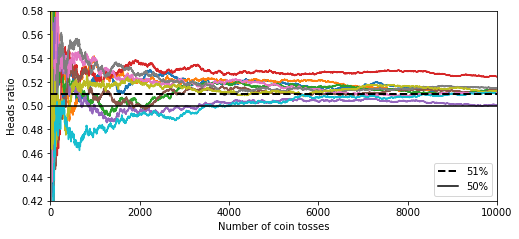

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
y_train

array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr',log_clf),('rf',rnd_clf),('svc',svm_clf)],
    voting='hard')
voting_clf.fit(X_train,y_train)

c:\users\jaesang\appdata\local\programs\python\python37\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.88
SVC 0.888
VotingClassifier 0.888


c:\users\jaesang\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


- 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높다

- 간접 투표 ( soft voting )
    - 개별 분류기의 예측을 평균 내어 가장 높은 클래스를 예측


In [9]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


c:\users\jaesang\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### 7.2 배깅과 페이스팅

- 다양한 분류기를 만드는 한가지 방법은 각기 다른 훈련 알고리즘을 사용하는 것
- 또 다른 방법은  <strong>같은 알고리즘은 사용하지만, 훈련 세트의 서브셋을 무작위로 구성하여
    분류기를 각기 다르게 학습시키는 것 </strong>
 
    - 배깅 ( Bagging = bootstrap aggregating = resampling )
    > - 훈련 세트에서 <strong>중복을 허용하여 </strong>샘플링 하는 방식
    - 페이스팅 ( Pasting )
    > - 훈련 세트에서 <strong>중복을 허용하지 않고</strong> 샘플링 하는 방식 

- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측값을 만듬
- 수집함수 ( = 샘플에 대한 예측값을 모으는 함수 )
> - 분류에서는 통계적 최빈값 ( = 직접 투표 분류기처럼 가장 많은 예측 결과 ) 
> - 회귀에서는 평균값 계싼 

- 개별 분류기는 원본 세트로 훈련 시키는 것 보다 훨씬 편향 (Bias)되어 있지만, 수집 함수를 통과하면 편향 ( Bias) 과 분산 ( Variance )이 모두 감소

- 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 떄 비교해 편향은 비슷하지만, 분산이 줄어듬

- 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습시킬 수 있고, 예측도 병렬로 수행할 수 있음 , 확장성이 좋음 = 배깅과 페이스팅



#### 여기서 잠깐! Bias, Variance ? 


- Bias
>- 학습 데이터를 충분히 표현할 수 없기 때문에 발생 ( underfitting )
>- Bias는 충분한 데이터가 있지만, 데이터 간의 상관관계를 충분히 풀어내지 못할 때 발생
>- 결과적으로 모델은 지속적으로 데이터를 잘못 표현하게 되고, 예측값은 .. 낮은 정답률을 내며 이 것을 underfitting 
    >- Bias 예제 
    >> - 색상과 모양으로 사물을 구분하는 모델
    >> - 색상 만으로 물체를 구분하는 모델을 만들면 , 오렌지, 레몬은 구분하기 어려움 

- Variance
>- 학습 데이터에 너무 민감하게 반응하여 발생 ( overfitting )







In [11]:
from sklearn.ensemble import BaggingClassifier # 회귀일 때는 BaggingRegressor 
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, # 500개의 예측기를 만듬
    max_samples=100, bootstrap= True, n_jobs=-1
) # n_job = -1 쓸 수 이있는 모든코어사용
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.92


In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [14]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

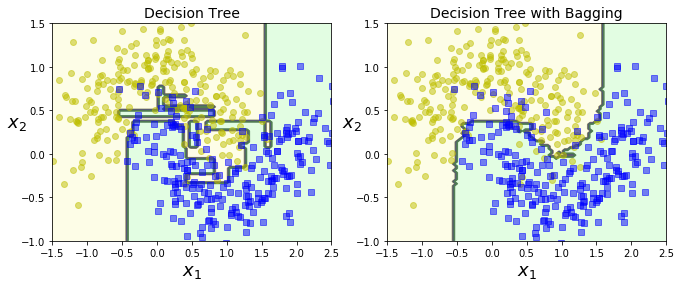

In [15]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Tree with Bagging", fontsize=14)
plt.show()

- 앙상블은 비슷한 편향에서 더 작은 분산을 만든다 ( = 훈련 세트의 오차수가 거의 비슷하지만 결정 경계가 덜 불규칙 ) 
- 부트스트래핑은 각 예측기가 학습한 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다
- 하지만 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소

- 전반적으로 배깅이 더 나은 모델을 만들기 때문에 더 선호
- 그러나 시간과 CPU가 여유가 있다면, 배깅과 페이스팅을 모두 평가해서 더 나은 쪽으로 ~

#### 7.2 oob 평가
---

- 배깅을 사용하면 어떤 샘플이 한 예측기를 위해 여러번 샘플링되고, 어떤 것은 전혀 선택되지 않을 수 있음 
- BagginClassifier는 기본으로 중복허용 ( bootstrap=True ) 훈련 세트의 크기 만큼 m개 샘플링함
>- 이는 평균적으로 각 예측기에 훈련 샘플의 63%만 샘플링 된다 

- 이렇게 선택되지 않은 37%의 나머지 샘플을 oob샘플이라고 한다 
> - 예측기마다 남겨진 37%는 모두 다르다 

- 예측기가 훈련되는 동안 oob 샘플을 사용하지 않으므로, 검증세트나 교차 검정을 사용하지 않고 oob 샘플을 사용해 평가할 수 있음
- <strong>앙상블의 평가는 각 예측기의 oob평가를 평균을 하여 얻습니다 </strong>

In [16]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500, # 500개의 예측기를 만듬
    max_samples=100, bootstrap= True, n_jobs=-1,oob_score=True 
) # n_job = -1 쓸 수 이있는 모든코어사용
bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.92

- oob 결과를 보면 이 분류기는 테스트 세트에서 약 92%의 정화도를 얻음

In [17]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.912

### 7.3 랜덤 패치와 랜덤 서브스페이스
--- 
- BaggingClassifier는 특성 샘플링도 지원
> - max_features
     - max_samples 과 비슷 ( 이 것은 샘플에 대한 샘플 )
> - bootstrap_features 
     - bootstrap 과 비슷

- 즉, 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련 
- 이미지 같은 매우 고차원 특성 데이터셋 다룰 때 유용

랜덤 패치 방식 ( Random Patch Method )
> - 훈련 특성과 샘플을 모두 샘플링하는 방식

랜덤 서브스페이스 방식 ( Random subspace Method ) 
> - 훈련 샘플을 모두 사용 하면서 ( bootstrap=False, max_samples=1.0 ) 
> - 훈련 특성은 샘플링하는 것 ( bootstrap_features = True, max_features < 1.0 )

특성 샘플링은 더 다양한 예측기를 만들며 
편향은 늘리는 대신, 분산을 낮춘다 

### 7.4 랜덤 포레스트 
--- 

- 랜덤 포레스트는 배깅 방법을 적용한 결정 트리의 앙상블
- 전형적으로 max_samples를 훈련 세트로 지정 
- BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신
- 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier 사용
  ( RandomForestRegressor )
- 랜덤 포레스트의 가장 핵심적인 특징은 임의성(randomness)에 의해 서로 조금씩 다른 특성을 갖는 트리들로 구성된다는 점

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
rnd_clf.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
y_pred_rf = rnd_clf.predict(X_test)

- 랜덤포레스트는 트리의 노드를 분할할 때, 전체 특성 중 에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 주입  
> - 결정트리는 각 노드에서 전체 특성을 대상으로 최선의 테스트를 찾음
> - 랜덤포레스트는 각 노드에서 후보 특성을 랜덤하게 선택한 후, 이 후보들 중에서 최선의 테스트 찾음



#### 7.4.1 엑스트라 트리 

- 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용
- 트리를 더욱 무작위하게 만들기 위해 최적의 임계값을 찾는 대신 ( 결정트리 처럼 )
- 후보 특성을 사용하여 무작위로 분할한다음 그 중에서 최상의 분할을 선택 

- 익스트림 랜덤 트리 ( Extremely Randomized Trees = Extra-Trees ) 앙상블
> - 극단적으로 무작위한 트리의 랜덤 포레스트
> - 편향은 늘어나는 대신 분산을 낮춤 
- 모든 노드에서 특성마다 가장 최적의 임계값을 찾는 것이 트리 알고리즘의 가장 많은 시간을 소요이기 때문에, 일반적인 랜덤 포레스트보다는 엑스트라 트리가 훨씬 빠름

#### 7.4.2 특성 중요도 

- 랜덤포레스트의 장점은 , 특성의 상대적 중요를 측정하기 쉽다
- 결정 트리를 기반으로 하는 모델은 모두 특성의 중요도를 제공 
> - DecisionTreeClassifier의 특성 중요도는 일부 특성을 완전히 배제시키지만, 
> - 무작위성이 주입된 RandomForestClassifier는 거의 모든 특성에 대한 평가할 기회가 있음 

- 중요도란?
> - 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요를 측정 ( 가중치의 평균 )
> - 사이킷런은 훈련이 끝난 뒤, 특성마다 자동으로 점수 계산후, 중요도의 합이 1이 되도록 정규화 ( = feature_importances_ 변수에 저장 ) 

In [20]:
from sklearn.datasets import load_iris
iris = load_iris()

rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rnd_clf.fit(iris["data"],iris["target"])
for name,score in zip(iris["feature_names"],rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.10346344626920408
sepal width (cm) 0.023241062712641532
petal length (cm) 0.44138588195295764
petal width (cm) 0.43190960906519643


In [21]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [22]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

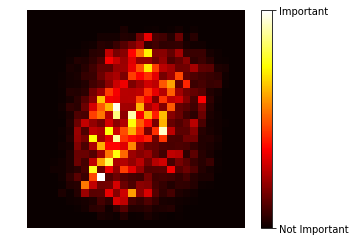

In [23]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not Important', 'Important'])

plt.show()

### 7.5 부스팅

- 약간 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블 방법
- 앞의 모델을 보완해나가면서, 일련의 예측기를 학습시키는 것
> - 아다부스트 ( AdaBoost )
> - 그래디언트부스트 ( Gradient Boost ) 


#### 7.5.1 아다부스트
- 이전 예측기를 보완하는 새로운 예측기를 만드는 방법
> - 이전 모델이 과소적합했던 훈련샘플에 가중치를 더 높이는 방법 
> - 새로운 예측기는 학습하기 어려운 샘플에 점점 맞춰짐

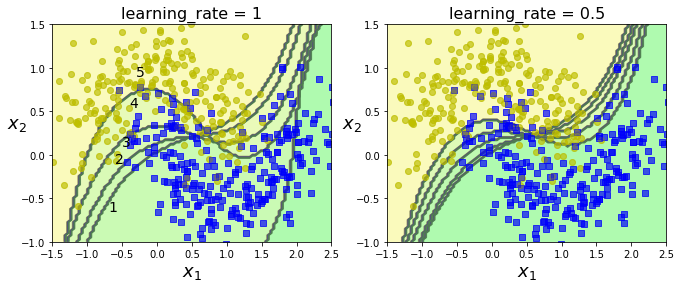

In [24]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)        
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.show()

In [78]:
for i in range(5):
        print(sample_weights[1])
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate) # learning_rate is 0.5


38.443359375
57.6650390625
57.6650390625
86.49755859375
86.49755859375


In [25]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, ## max_depth default 3 
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

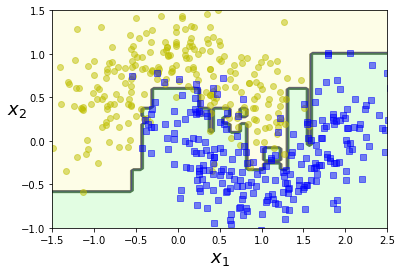

In [26]:
plot_decision_boundary(ada_clf, X, y)
plt.show()

### 7.2 그래디언트 부스팅


- 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가
- 아다부스트와 다르게 이전 샘플의 가중치를 수정하는 것이 아닌
- 이전 예측기가 만든 잔차 오차 ( Residual Error ) 에 새로운 예측기를 학습

- 회귀 문제에 잘 작동! 
- 그래디언트 트리 부스팅 또는 그래이언트 부스티드 회귀 트리 ( Gradient Tree Boosting / Gradient Boosted Regression Tree ( GBRT ))

In [27]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [30]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [36]:
y

array([ 5.15728987e-02,  5.94479790e-01,  1.66051606e-01, -7.01779562e-02,
        3.43985933e-01,  3.72874939e-01,  6.59764984e-01,  3.76341398e-01,
       -9.75194335e-03,  1.04794741e-01,  7.35287787e-01,  6.78883363e-01,
        3.05066318e-01,  2.73909733e-01,  3.08559932e-01,  3.49130363e-01,
        7.98606436e-02, -1.45444646e-02, -5.71096619e-03,  5.75800683e-02,
        5.23392240e-02,  4.02946793e-01,  1.29867214e-01,  4.18481141e-02,
       -6.49789982e-02,  2.22943721e-01,  2.53451786e-01, -3.95060058e-02,
        1.75570720e-02,  6.37324227e-01,  1.29006981e-01,  3.34391950e-01,
        5.80417870e-01,  6.00772381e-01,  5.54501010e-01,  2.84001079e-01,
        1.17538848e-01,  6.08765289e-01,  9.22073759e-02,  2.58225391e-02,
        4.26829699e-01, -5.83641153e-02,  7.07523289e-01,  5.40226226e-01,
        2.14112889e-01,  3.37711060e-02,  1.76497872e-01, -6.88843767e-02,
        3.58884053e-02,  4.07472924e-01,  6.12002352e-01,  1.98779325e-01,
        5.84460527e-01,  

In [37]:
y2

array([-0.07199323,  0.06591133,  0.04248548, -0.19374408,  0.22041981,
        0.24930881, -0.00114735, -0.15222706, -0.13331807, -0.01877138,
        0.07437546,  0.1503149 , -0.22350214,  0.15034361,  0.18499381,
        0.22556424, -0.04370548, -0.13811059, -0.12927709, -0.06598606,
       -0.0712269 , -0.08485003,  0.00630109, -0.08171801, -0.18854512,
        0.0993776 ,  0.12988566, -0.16307213, -0.10600905, -0.0235881 ,
        0.00544086,  0.21082582, -0.08049446,  0.07220392,  0.02593255,
        0.16043495, -0.00602728,  0.12096847, -0.03135875, -0.09774359,
       -0.06096712, -0.18193024,  0.04661096,  0.01165776,  0.09054676,
       -0.08979502,  0.05293175, -0.1924505 , -0.08767772,  0.2839068 ,
        0.08343389,  0.0752132 ,  0.05589207, -0.08607633, -0.17234608,
        0.0087933 , -0.03289674,  0.17739276, -0.08642889,  0.04545908,
       -0.12555055,  0.01717459, -0.16368755, -0.12355051,  0.03177594,
       -0.05274012,  0.18286595,  0.15963461,  0.06821878,  0.22

In [31]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [32]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [34]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred


array([0.75026781])

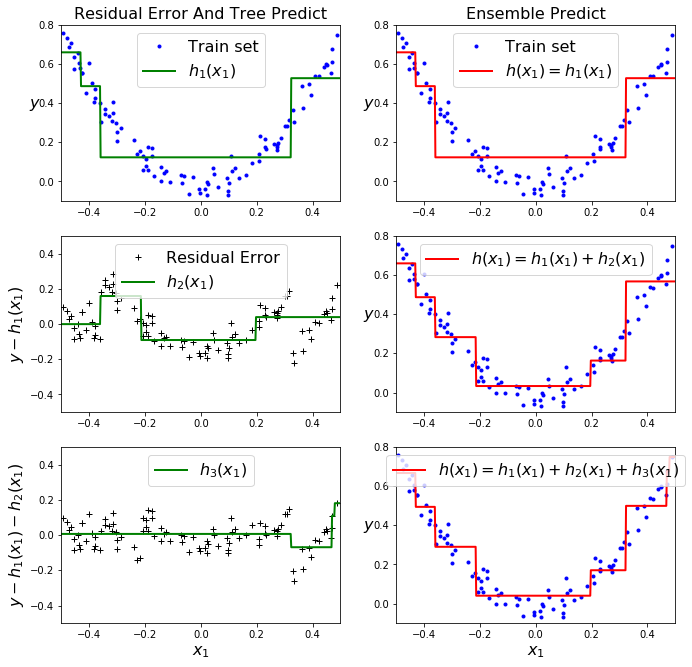

In [35]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Train set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residual Error And Tree Predict", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Train set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble Predict", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residual Error")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In [38]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [39]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)


- 축소 ( Shrinkage ) 규제 방법
>- 최적의 트리수를 찾기 위해 '조기 종료 기법'을 사용할 수 있음 
>- staged_predict()
>- 훈련의 각 단계 ( 트리 하나, 트리 두개 등 )에서 앙상블에 의해 만들어진 예측기를 순회하는 Iterator를 반환 


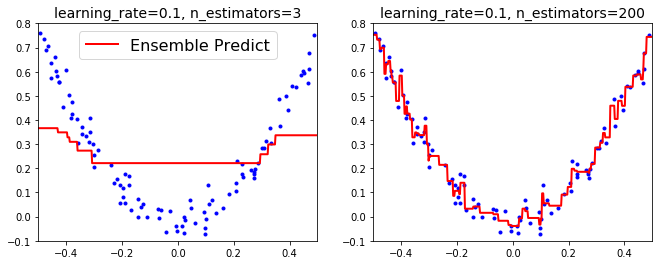

In [40]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble Predict")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

In [41]:
## 조기 종료 기법을 사용한 최적의 트리 수 찾기

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [42]:
min_error = np.min(errors)
min_error

0.002712853325235463

In [46]:
errors

[0.03976434066090687,
 0.03301153878946109,
 0.027663386192027795,
 0.023337263188229852,
 0.020390590545872743,
 0.017820174421765502,
 0.015262814214454865,
 0.013228529533567415,
 0.011758450328306618,
 0.010288335529306629,
 0.009391268210618017,
 0.008605826199167754,
 0.007745553291052828,
 0.007083571270654957,
 0.006766296135021012,
 0.006116142333014483,
 0.005770219779341232,
 0.005416351332327169,
 0.0050727394710244665,
 0.0048159263120028765,
 0.004357591913537005,
 0.004192866645244622,
 0.0039670672414243964,
 0.0038463154458755833,
 0.0037468374981679863,
 0.003530909744387239,
 0.0034677533859285626,
 0.0033882676886440523,
 0.003224220772589744,
 0.0031883136637545035,
 0.003166151135979498,
 0.003072276914292378,
 0.003024919266015998,
 0.002991089248190895,
 0.002957301355498197,
 0.0028890741785044197,
 0.0028849656803361795,
 0.0028902935070124736,
 0.002836717946434534,
 0.0028151139950619727,
 0.002805906789900023,
 0.002769821491376303,
 0.002775136129921357,
 

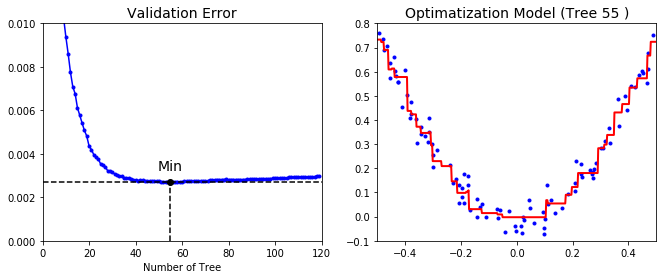

In [89]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Min", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of Tree")
plt.title("Validation Error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Optimatization Model (Tree %d )" % bst_n_estimators, fontsize=14)

plt.show()

- 위의 방법은 120개의 트리를 다 만들고, 그 중 에러가 가장 적은 트리의 개수를 선택하는 방법
- 실제로 훈련을 중지하는 방법으로 조기 종료를 구현할 수 있음
- warm_start=True ->  fit 메소드가호출될 때, 기존 트리를 유지하고 훈련을 추가할 수 있도록 해줌



In [48]:
## 다섯번의 반복동안 검증오차가 향상되지 않으면 훈련을 멈춤
## WARN_START 
## When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble,
## otherwise, just erase the previous solution.
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

In [49]:
print( gbrt.n_estimators)

61


In [50]:
print("최소 검증 MSE:", min_val_error)


최소 검증 MSE: 0.002712853325235463


## 7.6 스태킹

- 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신, 취합하는 모델을 훈련시킬 수는 없을까?
    - 블렌더 ( Blender || Meta Learner ) : 마지막 예측기를 만들자 ( 예측값을 받아 최종 예측을 하는 모델 ) 
    
- 블렌더를 학습하는 방법
    1. 홀드 아웃 ( hold-out )
    2. 아웃 오브 홀드 ( out-of-fold )
    
- 홀드 아웃 ( hold-out )
    - 훈련 세트를 두개의 서브셋으로 나눔 
    - 첫번쨰 서브셋은 첫번째 레이어릐 예측을 훈련 시키기 위해 사용
    - 위에서 학습한 예측기를 사용해 두번째 서브셋에대한 예측을 만듬
    -